# Tree Based Models
In this chapter, we talk about tree based models and its ensembled form(random forest and boosting).

## Basics of Decision Tree

Decision trees make excellent classifiers.  They are able to capture more complicated structure than linear models and a trained decision tree has an easy interpretation that matches the way humans approach many tasks.

A decision tree makes predictions by partitioning the input space, or the space that our data lives in, into regions and then assigning a label to each region. By repeatedly partitioning the space using multiple variables or splitting the same variable multiple times, decision trees can learn very complex classification rules that are hard to approximate with other models. 

Tree-based methods are nice because they can work with mixed data types (categorical, continuous, binary), they are quick to fit and predict with, they are interpretable, and their theoretical properties are relatively well-known. Some variantes of tree-based models can also deal with observations containing missing data, which is convenient. One disadvantage of trees is they can be highly sensitive to the data (this is called having a large *variance*) and they tend to overfit.

How does the decision tree decide where to split?  And how does it know which dimension to split on first?  These decisions will be determined by the mathematical formulation of the model, and we will omit them here. If you are interested in learning more, see <a href="https://en.wikipedia.org/wiki/Decision_tree_learning">this wikipedia article</a>.


The data we are using this time is called _German Credit Dataset_. Our goal is to predict whether a person will have loan default based on his/her demographic background.

In [1]:
# We begin by importing numpy and pandas, as usual.
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# We'll be evaluating our models as well.
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve

In [2]:
data = pd.read_csv('credit.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 17 columns):
checking_balance        1000 non-null object
months_loan_duration    1000 non-null int64
credit_history          1000 non-null object
purpose                 1000 non-null object
amount                  1000 non-null int64
savings_balance         1000 non-null object
employment_duration     1000 non-null object
percent_of_income       1000 non-null int64
years_at_residence      1000 non-null int64
age                     1000 non-null int64
other_credit            1000 non-null object
housing                 1000 non-null object
existing_loans_count    1000 non-null int64
job                     1000 non-null object
dependents              1000 non-null int64
phone                   1000 non-null object
default                 1000 non-null object
dtypes: int64(7), object(10)
memory usage: 132.9+ KB


In [3]:
data.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,yes,no
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,no,yes
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,no,no
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,no,no
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,no,yes


We need to clean the data first before feed into tree models. There are two things we need to do:
(1) Code variables that could take on only two possible values to be boolean variables.
(2) Create dummy variables for other categorical variables that could take on more than two possible values.

In [4]:
def mapping(value):
    if value=='yes':
        return True
    else:
        return False

In [5]:
data['phone'] = data['phone'].apply(mapping)
data['default'] = data['default'].apply(mapping)

In [6]:
data.head()

,checking_balance,months_loan_duration,credit_history,purpose,amount,savings_balance,employment_duration,percent_of_income,years_at_residence,age,other_credit,housing,existing_loans_count,job,dependents,phone,default
0,< 0 DM,6,critical,furniture/appliances,1169,unknown,> 7 years,4,4,67,none,own,2,skilled,1,True,False
1,1 - 200 DM,48,good,furniture/appliances,5951,< 100 DM,1 - 4 years,2,2,22,none,own,1,skilled,1,False,True
2,unknown,12,critical,education,2096,< 100 DM,4 - 7 years,2,3,49,none,own,1,unskilled,2,False,False
3,< 0 DM,42,good,furniture/appliances,7882,< 100 DM,4 - 7 years,2,4,45,none,other,1,skilled,2,False,False
4,< 0 DM,24,poor,car,4870,< 100 DM,1 - 4 years,3,4,53,none,other,2,skilled,2,False,True


In [7]:
dummy_columns = ['checking_balance', 'credit_history', 'purpose', 'savings_balance', 'employment_duration', 
                 'other_credit','housing','job']

cleaned_data = pd.get_dummies(data, columns = dummy_columns)

In [8]:
cleaned_data.head()

,months_loan_duration,amount,percent_of_income,years_at_residence,age,existing_loans_count,dependents,phone,default,checking_balance_1 - 200 DM,...,other_credit_bank,other_credit_none,other_credit_store,housing_other,housing_own,housing_rent,job_management,job_skilled,job_unemployed,job_unskilled
0,6,1169,4,4,67,2,1,True,False,0,...,0,1,0,0,1,0,0,1,0,0
1,48,5951,2,2,22,1,1,False,True,1,...,0,1,0,0,1,0,0,1,0,0
2,12,2096,2,3,49,1,2,False,False,0,...,0,1,0,0,1,0,0,0,0,1
3,42,7882,2,4,45,1,2,False,False,0,...,0,1,0,1,0,0,0,1,0,0
4,24,4870,3,4,53,2,2,False,True,0,...,0,1,0,1,0,0,0,1,0,0


All the new dummy variables for one variable have a redundant column, so I am removing them.(why are they redundant?)

In [9]:
cleaned_data = cleaned_data.drop(columns=['checking_balance_unknown','credit_history_very good'
                                          ,'purpose_car0','savings_balance_unknown','employment_duration_unemployed'
                                          ,'other_credit_store','housing_other','job_unemployed'])

There are several different classifiers in sklearn that depend on decision trees.  We will start with the simplest one, a single tree classifier.  These become the building blocks of more complicated models.

In [10]:
from sklearn.model_selection import train_test_split

Y = cleaned_data['default']
X = cleaned_data.drop('default', axis=1)

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.3, random_state = 2018,stratify = Y)

In [11]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()
dt.fit(Xtrain, Ytrain)
y_pred = dt.predict(Xtest)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [13]:
print("Accuracy is ",np.sum(y_pred==Ytest)/len(y_pred))
print("Precision is ",np.sum(y_pred & np.array(Ytest))/np.sum(y_pred))
print("Recall is ",np.sum(y_pred & np.array(Ytest))/np.sum(Ytest))

Accuracy is  0.64
Precision is  0.39285714285714285
Recall is  0.36666666666666664


In [14]:
#proportion of default observations among all the observations
np.sum(Ytest)/len(Ytest)

0.3

This classifier is not doing so well. What shall we do?

## Ensemble Models
Tree-based models provide a good introduction to a family of techniques called *ensembles*. 

Ensembles combine multiple models to achieve better predictions than the individual models alone. This is a powerful idea that has led to some of the best empirical results in many prediction competitions, as well as some useful theoretical developments.

We'll look at two different tree-based ensemble models today -- **random forests** and ** boosted trees**. However, ensembling can be applied to any type of model.

This will help you get a little bit of intuition.  Suppose that we had 4 models that were independent of each other.  The models make a correct prediction with the following probabilities:

<pre>

|       | Probability Correct | Probability Incorrect |
|-------|---------------------|-----------------------|
|Model 1|       0.70          |         0.30          |
|Model 2|       0.65          |         0.35          |
|Model 3|       0.60          |         0.40          |
|-------|---------------------|-----------------------|

</pre>

What is the probability that at least two models make the right prediction?

In [67]:
1-0.35*0.30*0.60-0.30*0.40*0.65-0.35*0.40*0.70-0.30*0.35*0.40

0.7190000000000001

## Random Forests
Random forests are collections of decision trees.  Each split of each tree learns on a different, randomly-selected subset of the columns in the data space.  Once all the trees are learned, the model combines the predictions into a better classifer. 

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200, max_features=6)
rf.fit(Xtrain, Ytrain)
y_pred = rf.predict(Xtest)
y_prob = rf.predict_proba(Xtest)

In [25]:
print("Accuracy is ",np.sum(y_pred==Ytest)/len(y_pred))
print("Precision is ",np.sum(y_pred & np.array(Ytest))/np.sum(y_pred))
print("Recall is ",np.sum(y_pred & np.array(Ytest))/np.sum(Ytest))

Accuracy is  0.7266666666666667
Precision is  0.5740740740740741
Recall is  0.34444444444444444


Because random forest generate a lot of new trees, we can have a probability of every observation having default loans. With these probabilities, we can generate a ROC curve.

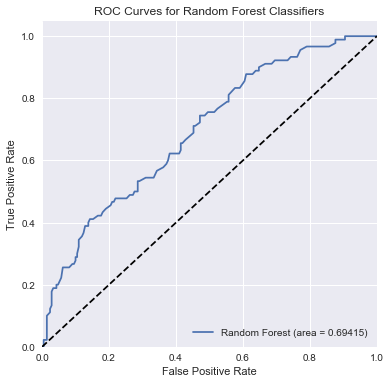

In [26]:
sns.set()
fig = plt.figure()
fig.set_size_inches(6,6)
fpr, tpr, _ = roc_curve(Ytest, y_prob[:,1])
plt.plot(fpr, tpr, label= 'Random Forest (area = %0.5f)' % roc(Ytest, y_prob[:,1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Random Forest Classifiers')
plt.legend(loc="lower right")
plt.show()

## Boosting

Another ensemble-based method to improve basic classification trees (or other methods) is called *boosting*. 

Boosting methods repeatedly learn a series of "weak learners" to classify the data, but at the end of each iteration, they also re-learn a set of *weights* on the training data that this learned misclassified. These weights are applied to the next iteration of training, so that the next model fits more closely to the misclassified points.

The boosting algorithm we'll look at here has essentialy two steps:
(1) build a *little* trees
(2) evaluate the error of that little tree
(3) update the weights of the training data variables based on these errors

These steps are repeated until the model's accuracy is not improving any longer.


In [18]:
from sklearn.ensemble import AdaBoostClassifier
adaboost = AdaBoostClassifier(n_estimators = 100, random_state=2018, learning_rate = 0.5)
adaboost.fit(Xtrain, Ytrain)
y_pred = adaboost.predict(Xtest)
y_prob = adaboost.predict_proba(Xtest)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=100, random_state=2018)

In [21]:
print("Accuracy is ",np.sum(y_pred==Ytest)/len(y_pred))
print("Precision is ",np.sum(y_pred & np.array(Ytest))/np.sum(y_pred))
print("Recall is ",np.sum(y_pred & np.array(Ytest))/np.sum(Ytest))

Accuracy is  0.6866666666666666
Precision is  0.47058823529411764
Recall is  0.35555555555555557


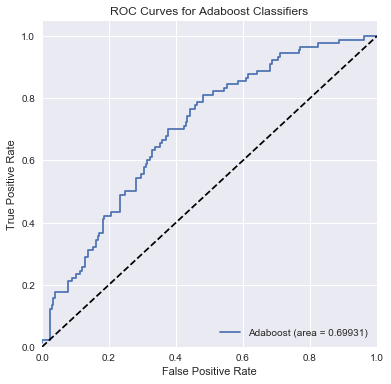

In [22]:
fig = plt.figure()
fig.set_size_inches(6,6)
fpr, tpr, _ = roc_curve(Ytest, y_prob[:,1])
plt.plot(fpr, tpr, label= 'Adaboost (area = %0.5f)' % roc(Ytest, y_prob[:,1]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Adaboost Classifiers')
plt.legend(loc="lower right")
plt.show()

## Variable Importance
Finally, let's look at variable importance. "Importance" measures how useful features are for predicting the outcome in a given model. This is a very useful way to interpret our model, given that it's very complicated to visualize.

Note: Importance is measured differently for different models, and these methods aren't necessarily equivalent, so importances aren't directly comparable across models. We generally use it to get a sense of which variables are most useful. Importance is particularly valuable for "black box" classifiers which don't have easily accessible/interpretable parameters.

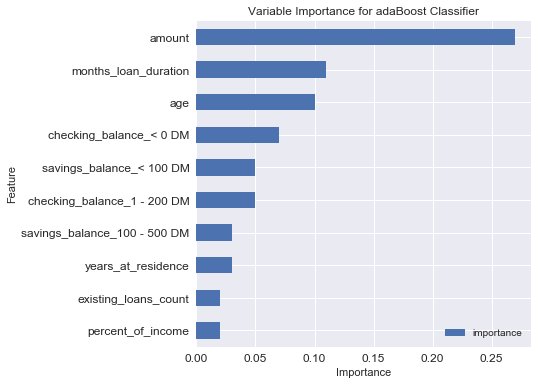

In [23]:
importances = adaboost.feature_importances_
imp_df = pd.DataFrame({'variable': Xtrain.columns.tolist(), 'importance': importances})
# create dataframe with top 10 by variable importance
df_top = imp_df.nlargest(10, columns = ['importance'], keep='first').sort_values(by = 'importance', ascending = True)
labs = df_top['variable']
fig = plt.figure()
df_top.plot.barh(fontsize = 12,  figsize = (6,6)).set_yticklabels(labs, rotation=0)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Variable Importance for adaBoost Classifier')
plt.show()

## Summary
1. Meaning of tree-based models
2. Random Forest
3. Boosting(adaboost)
4. Variable Importance